# Research question: What is the relationship between the SHAP and feature value?


## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebook (03_xgb_combined_shap_key_features.ipynb) we looked at SHAP values for all the features (fitting models to k-fold data and comparing the differences of the SHAP values obtained across the 5 models). 

In our previous notebook (03a_xgb_combined_shap_key_features.ipynb) we fited a single model to all of the data (no test set) and focused on understanding the SHAP values for each of the one-hot encoded hosptial features that make up the *Stroke team* categorical feature.

In 03d we saw an unexpected high correlation (0.44) between hosptial IVT rate and SHAP value for infarction (even though the SHAP value is small). When looked at main effect instead the correlation was lost. So it seems the correlation came from some leakage of hospital SHAP interactions into the Infarction SHAP value. So far in that notebook (03d) we looked at the two extremes: SHAP values (includes all interactions) and main effect (no ineractions). Since we're splitting the features into two groups (hospital ones, and patient ones) to fit a multiple regressions on, let's only include the SHAP interactions for the features that are in the same regression. So only the main effect and the interactions that are with the other features in the multiple regression. This way we have a bunch of SHAP interactions that are between the hostpial features and patient features. For completeness, fit a multiple regression on these. Do that in this notebook: Get main effect and interactions for features in multiple regression group, for each feature for each patient

In this notebook we used the model from notebook 03a (all data model) and focus on understanding how much of the variation in the hosptials thrombolysis rate can be attributed to the difference in the hospital processes, and to its different patient mix.

we will create a "subgroup SHAP value" for each feature. The 10 features in the model can be classified as either those that are describing the patients characteristics (the “patient descriptive features”) or those that are describing the hospital’s processes (the “hospital descriptive features”). There are eight patient descriptive features (age, stroke severity, prior disability, onset-to-arrival time, stroke type, type of onset time, anticoagulants, and onset during sleep) and there are two hospital descriptive features (arrival-to-scan time, and hospital attended). For this analysis, we only included the single one-hot encoded feature for the attended hospital (and did not include the other 131 one-hot encoded features for the unattended hospitals). We calculated the subgroup SHAP value for each feature by only including the components of it's SHAP value that exclusively contain the effect from the features in the same subgroup. This is expressed as the sum of the main effect and the interaction effects with the other features within it’s subgroup. For the feature “arrival to scan”, which is part of the hospital descriptive subgroup, its refined SHAP value is the main effect plus the interaction with the feature hospital attended. For each of the features in the patient descriptive subgroup, its refined SHAP value is the main effect plus the sum of the interactions with each of the other seven patient descriptive features. For each set of descriptive features (hospital and patient) we fitted a multiple regression to predict the hospitals observed thrombolysis rate from the mean refined SHAP value of each feature for patients attending each hospital (using values from the all data model).


SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we read in an already fitted XGBoost model to the SAMueL dataset (and the SHAP values), to predict whether a patient recieves thrombolysis from the values of 10 features, using all data to train (no test set). 

## Model and data

XGBoost model was trained on all of the data (no test set used). The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data (no test set) to predict whether patient gets thrombolysis
* Calculate the SHAP values of the features
* Understand the relationship between the SHAP value and feature values for all features (apart from the hospital feature)

## Observations
* Stroke type: The SHAP values for stroke type show that the model effectively eliminated any probability of receiving thrombolysis for non-ischaemic (haemorrhagic) stroke.
*  Arrival-to-scan time: The odds of receiving thrombolysis reduced by about 20 fold over the first 100 minutes of arrival to scan time.
* Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again with higher stroke severity (NIHSS above 25). The difference between minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving thrombolysis was 30-35 fold.
* Stroke onset time type (precise vs. estimated): The odds of receiving thrombolysis were about 3 fold greater for precise onset time than estimated onset time.
* Disability level (mRS) before stroke: The odds of receiving thrombolysis fell about 5 fold between mRS 0 and 5.

### Extra code to check something for the paper

In notebook 03_xgb_combined_shap_key_features.ipynb we used the training set from the first kfold to plot the feature value vs SHAP for the top 6 influencial features.

Here we use the 'all data model', and look at all features to inform the subgroup analysis (to include all features for that too, rather than the selected 3 features)

## Show the relationship between feature value and SHAP value for all the features

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from sklearn import linear_model

import os
import pickle

import math # to .floor and .ceil

# So can take deep copy
import copy

from os.path import exists
import json

/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03g'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Get list of feature names
And remove Thrombolysis (as not a value to get the mean for)

In [14]:
feature_names = list(test_data_kfold[0])
feature_names.remove('Thrombolysis')

### Define the features in each multiple regression

Have two multiple regressions: patient and hosptial

In [24]:
patient_features = ['Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

hospital_features = ['Arrival-to-scan time']

Get unique teams list

In [16]:
unique_stroketeams_list = list(set(data["Stroke team"]))

## Get mean feature values per hosptial

In [18]:
df_hosp_mean_feature_values = data.groupby('Stroke team').mean()

In [19]:
df_hosp_mean_feature_values

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,Thrombolysis
Stroke team,,,,,,,,,,
AGNOF1041H,43.087256,0.846154,10.362801,0.716418,0.941447,0.129736,110.799082,0.041332,74.537887,0.352468
AKCGO9726K,56.190476,0.916667,8.357843,0.501401,1.168768,0.116947,116.791317,0.084034,73.317577,0.369748
AOBTM3098N,196.020513,0.866667,9.082051,0.705983,1.008547,0.133333,113.647863,0.083761,77.089744,0.218803
APXEE8191H,120.423345,0.783972,8.297909,0.393728,1.062718,0.170732,110.296167,0.052265,77.338850,0.226481
ATDID5461S,183.057692,0.817308,10.355769,0.647436,1.282051,0.115385,96.304487,0.009615,78.493590,0.240385
...,...,...,...,...,...,...,...,...,...,...
YPKYH1768F,110.927445,0.854890,8.422713,0.738170,1.138801,0.100946,98.135647,0.037855,72.358044,0.246057
YQMZV4284N,98.010638,0.859574,9.119149,0.544681,1.717021,0.119149,118.517021,0.295745,78.351064,0.236170
ZBVSO0975W,74.335648,0.821759,9.976852,0.842593,0.891204,0.122685,107.578704,0.006944,76.574074,0.250000


In [21]:
def plot_regressions(df_hosp_mean, features, title):
    for feat in features: 
        # Setup data for chart
        x = df_hosp_mean[feat]
        y = df_hosp_mean['Thrombolysis']

        # Fit a regression line to the x2 points
        slope, intercept, r_value, p_value, std_err = \
            stats.linregress(x, y)
        r_square = r_value ** 2
        y_pred = intercept + (x * slope)

        # Create scatter plot with regression line
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)

        ax.scatter(x, y, color = 'k', marker="o", s=20)
        ax.plot (x, y_pred, color = 'k', linestyle='--', linewidth=1)

        ax.set_xlabel(f"{title} {feat} "
                      f"\n(mean of the instances that attend the hospital)")
        ax.set_ylabel('Thrombolysis rate')

        (xmin, xmax) = ax.get_xlim()
        (ymin, ymax) = ax.get_ylim()
#        axis_min = min(xmin, ymin)
#        axis_max = max(xmax, ymax)

#        ax.set_xlim((axis_min, axis_max))
#        ax.set_ylim((axis_min, axis_max))
    #    ax.set_ylim(0, 0.5)
    #    ax.set_xlim(-1.5, 1.5)


        plt.grid()

        # Add  text
        f = (str("{:.2f}".format(slope)) + 'x + ' + 
              str("{:.2f}".format(intercept)))
        text = (f'R squared: {r_square:.3f}\np: '
                 f'{p_value:0.4f}\nformula: {f}')

    
        x_placement = xmin + 0.05*(xmax - xmin)
        y_placement = ymax - 0.15*(ymax - ymin)
        ax.text(x_placement, y_placement, text,
                 bbox=dict(facecolor='white', edgecolor='white'))

#        ax.text(1.3*x_axis_min, 0.85*y_axis_max, text,
#                 bbox=dict(facecolor='white', edgecolor='white'))

        # Save figure

    #    plt.savefig(f'./output/{notebook}_{model_text}'
    #                f'_attended_hosp_shap_value.jpg', 
    #                dpi=300, bbox_inches='tight', pad_inches=0.2)
        plt.show()
    
    return()

### Regression on patient characteristics vs IVT rate

In [22]:
def fit_and_plot_multiple_regression(df_hosp_mean, features):
    X = df_hosp_mean[features]
    y = df_hosp_mean['Thrombolysis']

    regr = linear_model.LinearRegression()
    regr.fit(X, y)

    df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features, columns=["coeff"])
    print(df_reg_coeff)

    # performance
    y_pred = regr.predict(X)

    # Fit a regression line to the obs and pred IVT use
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(y, y_pred)
    r_square = r_value ** 2
    y_pred_line = intercept + (y * slope)
    
    # Create scatter plot with regression line
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)

    ax.scatter(y_pred, y, color = 'k', marker="o", s=20)
    ax.plot (y_pred_line, y, color = 'k', linestyle='--', linewidth=1)

    (xmin, xmax) = ax.get_xlim()
    (ymin, ymax) = ax.get_ylim()
    axis_min = min(xmin, ymin)
    axis_max = max(xmax, ymax)
    
    ax.set_xlim(axis_min, axis_max)
    ax.set_ylim(axis_min, axis_max)

    ax.set_xlabel(f"Thrombolysis rate (predicted)")
    ax.set_ylabel('Thrombolysis rate (observed)')

    plt.grid()

    # Add  text
    f = (str("{:.2f}".format(slope)) + 'x + ' + 
          str("{:.2f}".format(intercept)))
    text = (f'R squared: {r_square:.3f}\np: '
             f'{p_value:0.4f}\nformula: {f}')

    
    x_placement = axis_min + 0.05*(axis_max - axis_min)
    y_placement = axis_max - 0.15*(axis_max - axis_min)
    ax.text(x_placement, y_placement, text,
             bbox=dict(facecolor='white', edgecolor='white'))

    # Save figure

#    plt.savefig(f'./output/{notebook}_{model_text}'
#                f'_attended_hosp_shap_value.jpg', 
#                dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()
    return()

Regression between hosptial IVT rate and it's patients mean patient feature value


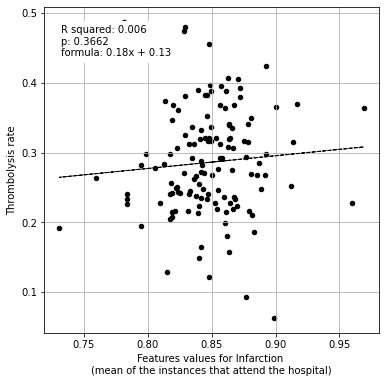

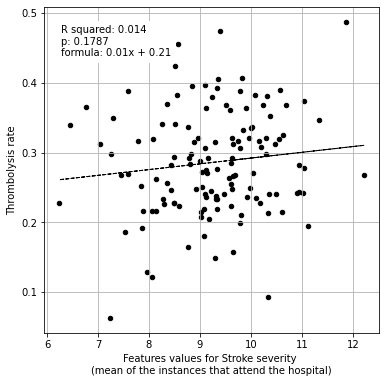

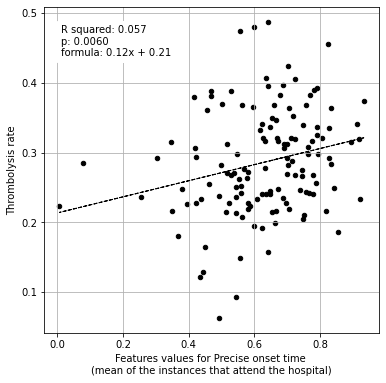

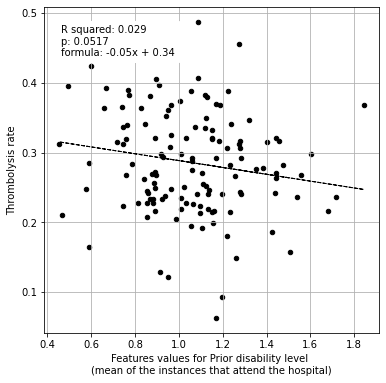

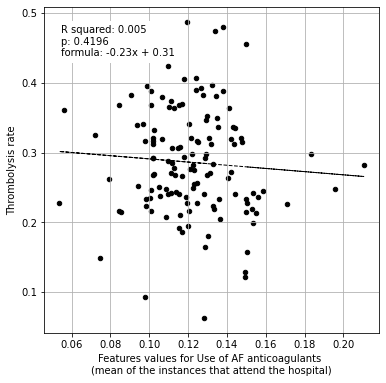

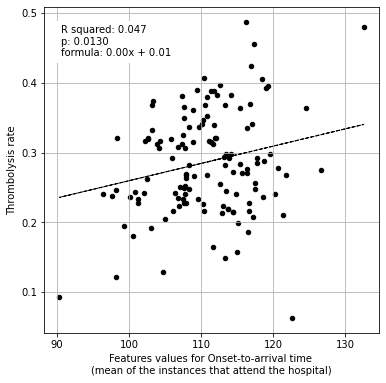

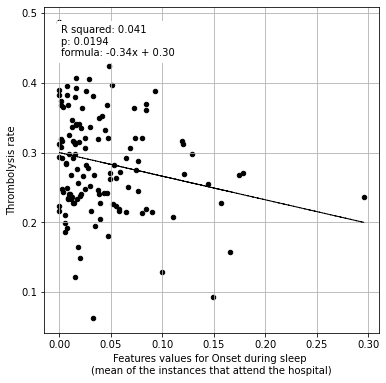

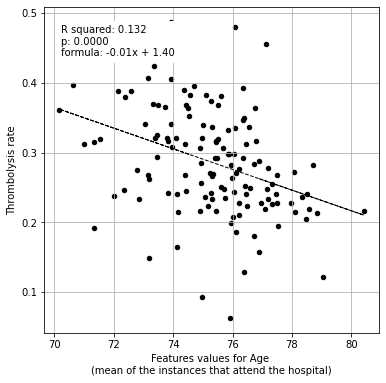


Multiple regression between hosptial IVT rate and it's patients mean patient feature values
                             coeff
Infarction                0.198321
Stroke severity           0.011381
Precise onset time        0.077898
Prior disability level   -0.011695
Use of AF anticoagulants  0.106239
Onset-to-arrival time     0.002768
Onset during sleep       -0.274212
Age                      -0.014752


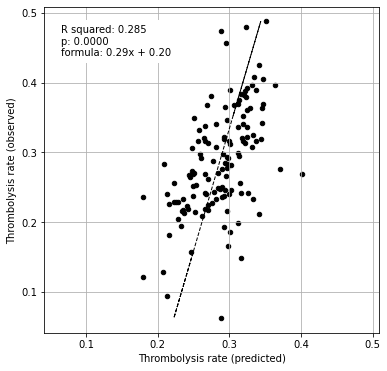


Regression between hosptial IVT rate and it's patients mean hospital feature value


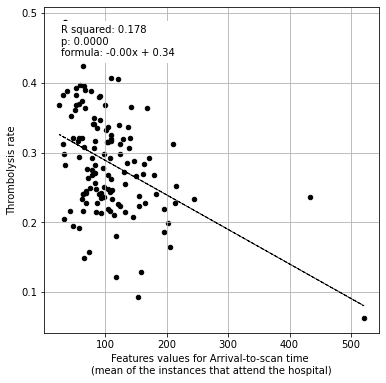


Multiple regression between hosptial IVT rate and it's patients mean hospital feature values
                         coeff
Arrival-to-scan time -0.000494


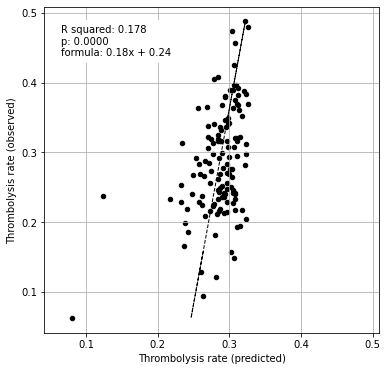


Multiple regression between hosptial IVT rate and it's patients mean feature values (both patient and hospital
                             coeff
Arrival-to-scan time     -0.000437
Infarction                0.415329
Stroke severity           0.005657
Precise onset time        0.041407
Prior disability level   -0.005062
Use of AF anticoagulants  0.182411
Onset-to-arrival time     0.002067
Onset during sleep       -0.310098
Age                      -0.013108


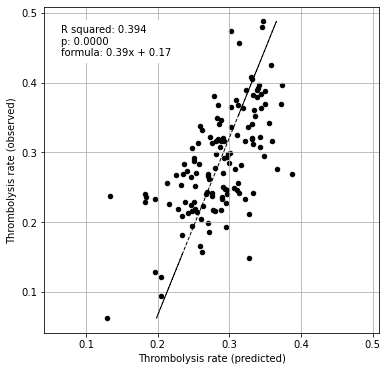

()

In [25]:
title = "Features values for"
df = df_hosp_mean_feature_values

print("Regression between hosptial IVT rate and it's patients mean patient "
      "feature value")
plot_regressions(df, patient_features, title)
print ()
print("Multiple regression between hosptial IVT rate and it's patients mean "
      "patient feature values")
fit_and_plot_multiple_regression(df, patient_features)

print ()
print("Regression between hosptial IVT rate and it's patients mean hospital "
      "feature value")
plot_regressions(df, hospital_features, title)
print ()
print("Multiple regression between hosptial IVT rate and it's patients mean "
      "hospital feature values")
fit_and_plot_multiple_regression(df, hospital_features)
print ()

print("Multiple regression between hosptial IVT rate and it's patients mean "
      "feature values (both patient and hospital")
fit_and_plot_multiple_regression(df, hospital_features + patient_features)